In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import Levenshtein
import librosa
import matplotlib.pyplot as plt
import MorseCodePy as mcp
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import re

## data

In [2]:
class ListDataset(torch.utils.data.Dataset):
    def __init__(self, features: list, labels: list, transform = lambda x: x):
        self.features = features
        self.labels = labels
        assert len(features) == len(labels)
        self.transform = transform
        pass

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.transform(self.features[index]), self.labels[index]

In [3]:
rng = np.random.default_rng()

def rotation_transform(tensor: torch.Tensor):
    threshold = rng.integers(0, tensor.shape[0])
    result = torch.concat([tensor[threshold:], tensor[:threshold]], dim=0)
    return result

In [8]:
full_train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
all_filenames = (list(train_df['id']) + list(test_df['id']))
len(all_filenames)

35000

In [ ]:
# n_fft = 512
# n_channels = 64

# audio_dir = 'morse_dataset'
# dir_to_save = dir_to_save = f'data/melspec_nfft{n_fft}_nc{n_channels}'
# Path(dir_to_save).mkdir(exist_ok=True)

# all_features = []

# for name in tqdm(all_filenames):
#     signal, sr = librosa.load(Path(audio_dir, name), sr=None)
#     melspectrogram = librosa.feature.melspectrogram(y=signal, sr = sr,
# 												n_mels = n_channels, n_fft=n_fft, hop_length=n_fft // 4)
    
#     melspectrogram = torch.as_tensor(melspectrogram, dtype=torch.float32)
#     torch.save(melspectrogram, Path(dir_to_save, Path(name).with_suffix('.pt')))
#     # all_features.append(melspectrogram)

# # len(all_features)

100%|██████████| 35000/35000 [12:18<00:00, 47.41it/s]


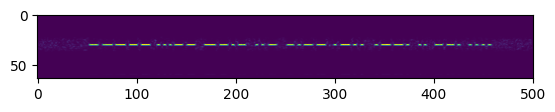

In [ ]:
# plt.imshow(torch.load(Path(dir_to_save, '1.pt'), weights_only=True))

In [10]:
def load_tensors(dir_path, filenames):
    for name in filenames:
        path = Path(dir_path, name)
        yield torch.load(path, weights_only=True)

In [ ]:
def filenames_to_torch(filenames):
    for name in filenames:
        yield Path(name).with_suffix('.pt')

# full_train_features = list(tqdm(load_tensors('/kaggle/input/kc25-melspec-data/melspec_nfft512_nc64', filenames_to_torch(full_train_df['id']))))
# full_train_labels = list(full_train_df['message'])
# len(full_train_features)

In [25]:
from sklearn.model_selection import train_test_split

# pftds_with_augs = ListDataset(full_train_features, full_train_labels, transform=rotation_transform)
# pftds_no_augs = ListDataset(full_train_features, full_train_labels)

# precomputed_full_train_dataset = ListDataset(full_train_features, full_train_labels)
train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
print(train_index.shape, val_index.shape)
val_features = list(tqdm(load_tensors('data/melspec_nfft512_nc64', filenames_to_torch(list(full_train_df.iloc[val_index]['id'])))))
val_labels = list(full_train_df.iloc[val_index]['message'])
# trainset = torch.utils.data.Subset(pftds_with_augs, train_index)
valset = ListDataset(val_features, val_labels)
print(len(valset))

(25000,) (5000,)


0it [00:00, ?it/s]

5000it [00:02, 1756.27it/s]

5000


## model

In [ ]:
class ResBlock(nn.Module):
        def __init__(self, size, p_dropout):
            super().__init__()
            self.cell = nn.Sequential(
                nn.Conv1d(size, size, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(size),
                nn.Dropout(p=p_dropout),
                nn.Conv1d(size, size, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(size),
                nn.Dropout(p=p_dropout),
            )
            self.activation = nn.ReLU()
            pass

        def forward(self, x):
            return self.activation(x + self.cell(x))
        pass


class MySomething(nn.Module):
    def __init__(self, n_pooled_blocks = 3, n_head_blocks = 2, pooled_blocks_thickness=1, input_size = 64, inner_size = 64, output_size = 5, p_dropout = 0.1):
        super().__init__()
        self.estimator = nn.Sequential(
            nn.Conv1d(input_size, inner_size, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(inner_size),
            nn.Dropout(),
            *[
                 nn.Sequential(
                    *[ResBlock(inner_size, p_dropout) for i_ in range(pooled_blocks_thickness)],
                    nn.MaxPool1d(kernel_size=2, stride=2),
                    ) for _ in range(n_pooled_blocks)
            ],
            *[ResBlock(inner_size, p_dropout) for _ in range(n_head_blocks)],
            nn.Conv1d(inner_size, output_size, kernel_size=3),
        )
        pass

    def forward(self, x):
        return self.estimator(x)

In [28]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [29]:
index_to_letter = sorted(set(''.join(train_df['message'])))
print(index_to_letter)
letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
dictionary_size = len(index_to_letter)
print(dictionary_size)
print(letter_to_index)

[' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
44
{' ': 0, '#': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'А': 12, 'Б': 13, 'В': 14, 'Г': 15, 'Д': 16, 'Е': 17, 'Ж': 18, 'З': 19, 'И': 20, 'Й': 21, 'К': 22, 'Л': 23, 'М': 24, 'Н': 25, 'О': 26, 'П': 27, 'Р': 28, 'С': 29, 'Т': 30, 'У': 31, 'Ф': 32, 'Х': 33, 'Ц': 34, 'Ч': 35, 'Ш': 36, 'Щ': 37, 'Ъ': 38, 'Ы': 39, 'Ь': 40, 'Э': 41, 'Ю': 42, 'Я': 43}


In [30]:
class Vectorizer:
    def __init__(self):
        self.text_to_nums = letter_to_index
        self.nums_to_text = index_to_letter
        pass

    def to_tensor(self, text: str):
        return torch.tensor([self.text_to_nums[ch] for ch in text])
    
    def from_tensor(self, tensor: torch.Tensor):
        assert tensor.ndim == 1
        return ''.join([self.nums_to_text[num.item()] for num in tensor])

In [31]:
vec_maker = Vectorizer()

def text_transform(text: str):
    return vec_maker.to_tensor(text) + 1 # for CTC loss

def batch_text_transform(texts: list[str], pad_value = 0):
    vecs = []
    for t in texts:
        vecs.append(text_transform(t))
    lengths = torch.tensor([len(v) for v in vecs])
    desired_length = torch.max(lengths)
    vecs = [F.pad(v, (0, desired_length - len(v)), value=pad_value) for v in vecs]
    batch = torch.stack(vecs, dim=0)
    return batch, lengths

In [32]:
batch_text_transform([train_df['message'][384], train_df['message'][545]])

(tensor([[14, 22, 15, 25, 37, 23, 31,  1, 13,  3,  4],
         [24, 14, 19, 44, 19, 25, 36, 16, 18, 16,  0]]),
 tensor([11, 10]))

In [39]:
"""
Author: Awni Hannun
This is an example CTC decoder written in Python. The code is
intended to be a simple example and is not designed to be
especially efficient.
The algorithm is a prefix beam search for a model trained
with the CTC loss function.
For more details checkout either of these references:
  https://distill.pub/2017/ctc/#inference
  https://arxiv.org/abs/1408.2873
"""

import numpy as np
import math
import collections

NEG_INF = -float("inf")

class LongCTCSampler:
  @staticmethod
  def make_new_beam():
    fn = lambda : (NEG_INF, NEG_INF)
    return collections.defaultdict(fn)

  @staticmethod
  def logsumexp(*args):
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max)
                        for a in args))
    return a_max + lsp

  @staticmethod
  def decode(probs, beam_size=100, blank=0):
    """
    Performs inference for the given output probabilities.
    Arguments:
        probs: The output probabilities (e.g. post-softmax) for each
          time step. Should be an array of shape (time x output dim).
        beam_size (int): Size of the beam to use during inference.
        blank (int): Index of the CTC blank label.
    Returns the output label sequence and the corresponding negative
    log-likelihood estimated by the decoder.
    """
    T, S = probs.shape
    probs = np.log(probs)

    # Elements in the beam are (prefix, (p_blank, p_no_blank))
    # Initialize the beam with the empty sequence, a probability of
    # 1 for ending in blank and zero for ending in non-blank
    # (in log space).
    beam = [(tuple(), (0.0, NEG_INF))]

    for t in range(T): # Loop over time

      # A default dictionary to store the next step candidates.
      next_beam = LongCTCSampler.make_new_beam()

      for s in range(S): # Loop over vocab
        p = probs[t, s]

        # The variables p_b and p_nb are respectively the
        # probabilities for the prefix given that it ends in a
        # blank and does not end in a blank at this time step.
        for prefix, (p_b, p_nb) in beam: # Loop over beam

          # If we propose a blank the prefix doesn't change.
          # Only the probability of ending in blank gets updated.
          if s == blank:
            n_p_b, n_p_nb = next_beam[prefix]
            n_p_b = LongCTCSampler.logsumexp(n_p_b, p_b + p, p_nb + p)
            next_beam[prefix] = (n_p_b, n_p_nb)
            continue

          # Extend the prefix by the new character s and add it to
          # the beam. Only the probability of not ending in blank
          # gets updated.
          end_t = prefix[-1] if prefix else None
          n_prefix = prefix + (s,)
          n_p_b, n_p_nb = next_beam[n_prefix]
          if s != end_t:
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_b + p, p_nb + p)
          else:
            # We don't include the previous probability of not ending
            # in blank (p_nb) if s is repeated at the end. The CTC
            # algorithm merges characters not separated by a blank.
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_b + p)
            
          # *NB* this would be a good place to include an LM score.
          next_beam[n_prefix] = (n_p_b, n_p_nb)

          # If s is repeated at the end we also update the unchanged
          # prefix. This is the merging case.
          if s == end_t:
            n_p_b, n_p_nb = next_beam[prefix]
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_nb + p)
            next_beam[prefix] = (n_p_b, n_p_nb)

      # Sort and trim the beam before moving on to the
      # next time-step.
      beam = sorted(next_beam.items(),
              key=lambda x : LongCTCSampler.logsumexp(*x[1]),
              reverse=True)
      beam = beam[:beam_size]

    best = beam[0]
    return best[0], -LongCTCSampler.logsumexp(*best[1])
  
  @staticmethod
  def sample(probs: torch.Tensor, beam_size=100):
    # probs.shape = [C, T]
    sequence, likelihood = LongCTCSampler.decode(np.asarray(probs.transpose(1, 0)), beam_size=beam_size)
    return sequence, likelihood
  
  @staticmethod
  def sample_in_morse(probs: torch.Tensor, beam_size=100, return_prob=False):
    sequence, likelihood = LongCTCSampler.sample(probs, beam_size=beam_size)
    morse = map_to_string(torch.tensor(sequence))
    morse = morse.strip(' /')
    if return_prob:
      return morse, likelihood
    return morse

In [35]:
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [38]:
n_epochs = 30


n_pooled_blocks = 4
n_head_blocks = 2
batch_size = 128
lr = 0.005
# n_blocks = 12
inner_size = 64
# exp_gamma = 0.8
step_gamma = 0.359
p_dropout = 0.165

model = MySomething(n_pooled_blocks = n_pooled_blocks, n_head_blocks = n_head_blocks,
                    input_size = 64, inner_size = inner_size, output_size = dictionary_size + 1,
                    p_dropout = p_dropout).to(device)
model.load_state_dict(torch.load('models/cnn_ctc/best_params_retrained_30ep.pt', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

У5БП Ю9В


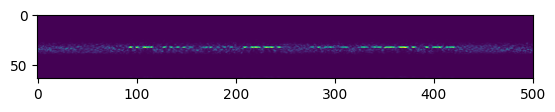

(32, 8, 14, 28, 1, 43, 12, 15)
У5БП Ю9В


In [40]:
model.eval()
with torch.no_grad():
    features, labels = valset[392]
    print(labels)
    plt.imshow(features)
    plt.show()
    features = features.to(device)
    outs = model(features[None]).squeeze().to('cpu')
    probs = F.softmax(outs, dim=0)
    seqs, likelihood = LongCTCSampler.sample(probs, beam_size=10)
    print(seqs)
    text = vec_maker.from_tensor(torch.tensor(seqs) - 1)
    print(text)
    

In [41]:
model.eval()
with torch.no_grad():
    distance_buffer = []
    for features, labels in tqdm([valset[i] for i in range(1000)]):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        seqs, likelihood = LongCTCSampler.sample(probs, beam_size=10)
        text = vec_maker.from_tensor(torch.tensor(seqs) - 1)
        decoded_message = text
        dist = Levenshtein.distance(decoded_message, labels)
        distance_buffer.append(dist)
    mean_dist = np.mean(distance_buffer)
mean_dist

100%|██████████| 1000/1000 [01:27<00:00, 11.40it/s]


np.float64(0.511)

In [43]:
model.eval()
with torch.no_grad():
    distance_buffer = []
    for features, labels in tqdm([valset[i] for i in range(1000)]):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        seqs, likelihood = LongCTCSampler.sample(probs, beam_size=20)
        text = vec_maker.from_tensor(torch.tensor(seqs) - 1)
        decoded_message = text
        dist = Levenshtein.distance(decoded_message, labels)
        distance_buffer.append(dist)
    mean_dist = np.mean(distance_buffer)
mean_dist

100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


np.float64(0.511)

In [44]:
model.eval()
with torch.no_grad():
    distance_buffer = []
    for features, labels in tqdm([valset[i] for i in range(1000)]):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        seqs, likelihood = LongCTCSampler.sample(probs, beam_size=5)
        text = vec_maker.from_tensor(torch.tensor(seqs) - 1)
        decoded_message = text
        dist = Levenshtein.distance(decoded_message, labels)
        distance_buffer.append(dist)
    mean_dist = np.mean(distance_buffer)
mean_dist

100%|██████████| 1000/1000 [00:42<00:00, 23.79it/s]


np.float64(0.513)

In [45]:
model.eval()
with torch.no_grad():
    distance_buffer = []
    for features, labels in tqdm([valset[i] for i in range(1000)]):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        seqs, likelihood = LongCTCSampler.sample(probs, beam_size=3)
        text = vec_maker.from_tensor(torch.tensor(seqs) - 1)
        decoded_message = text
        dist = Levenshtein.distance(decoded_message, labels)
        distance_buffer.append(dist)
    mean_dist = np.mean(distance_buffer)
mean_dist

100%|██████████| 1000/1000 [00:24<00:00, 41.29it/s]


np.float64(0.513)